In [9]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
from plotnine import ggplot, aes, geom_tile, scale_fill_gradient, theme_minimal, theme, geom_boxplot
from plotnine import ggsave, scale_y_reverse, labs, scale_fill_gradient2,geom_line,geom_point,scale_color_manual,geom_text
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,roc_curve, auc
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
import xgboost as xgb
from tqdm import tqdm
import Standardizer
import Encoder
import Interaction
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error,mean_squared_error,explained_variance_score
import shap

In [10]:
college_data = pd.read_csv('location_class_college.csv')
NYC_data = pd.read_csv('location_class_newyork.csv')
PHI_data = pd.read_csv('location_class_philly.csv')
STL_data = pd.read_csv('location_class_stlouis.csv')
data = pd.concat([college_data,NYC_data,PHI_data,STL_data])

In [11]:
data.info()
df = data

<class 'pandas.core.frame.DataFrame'>
Index: 8097 entries, 0 to 1477
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   store_id                  8097 non-null   int64  
 1   date                      8097 non-null   object 
 2   total.sales               8097 non-null   float64
 3   location_class            8097 non-null   object 
 4   dayofweek                 8097 non-null   object 
 5   total_promotions          8097 non-null   int64  
 6   type_PointsBonus          8097 non-null   int64  
 7   type_FreeProduct          8097 non-null   int64  
 8   type_ProductDiscount      8097 non-null   int64  
 9   type_FreeDelivery         8097 non-null   int64  
 10  type_OverallDiscount      8097 non-null   int64  
 11  channel_All               8097 non-null   int64  
 12  channel_Ecomm             8097 non-null   int64  
 13  channel_InStore           8097 non-null   int64  
 14  channel_Deliv

C:\Users\mmcdo\AppData\Local\Temp\ipykernel_22308\1443128277.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



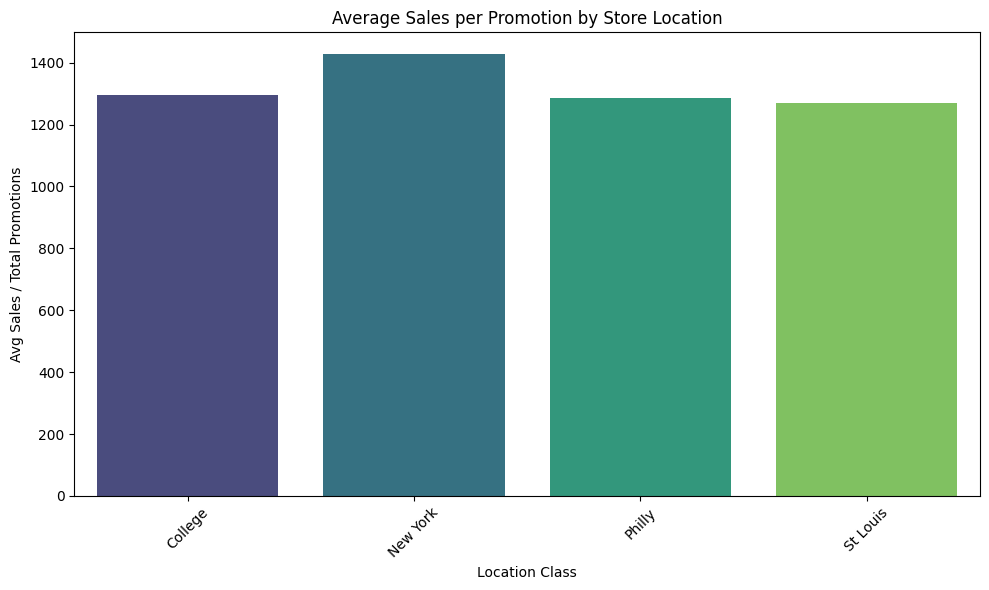

In [12]:
# Step 1: Create a new column for sales per promotion
df["sales_per_promo"] = df["total.sales"] / df["total_promotions"].replace(0, pd.NA)

# Step 2: Group by location_class and compute average
avg_sales = df.groupby("location_class")["sales_per_promo"].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_sales, x="location_class", y="sales_per_promo", palette="viridis")
plt.title("Average Sales per Promotion by Store Location")
plt.xlabel("Location Class")
plt.ylabel("Avg Sales / Total Promotions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

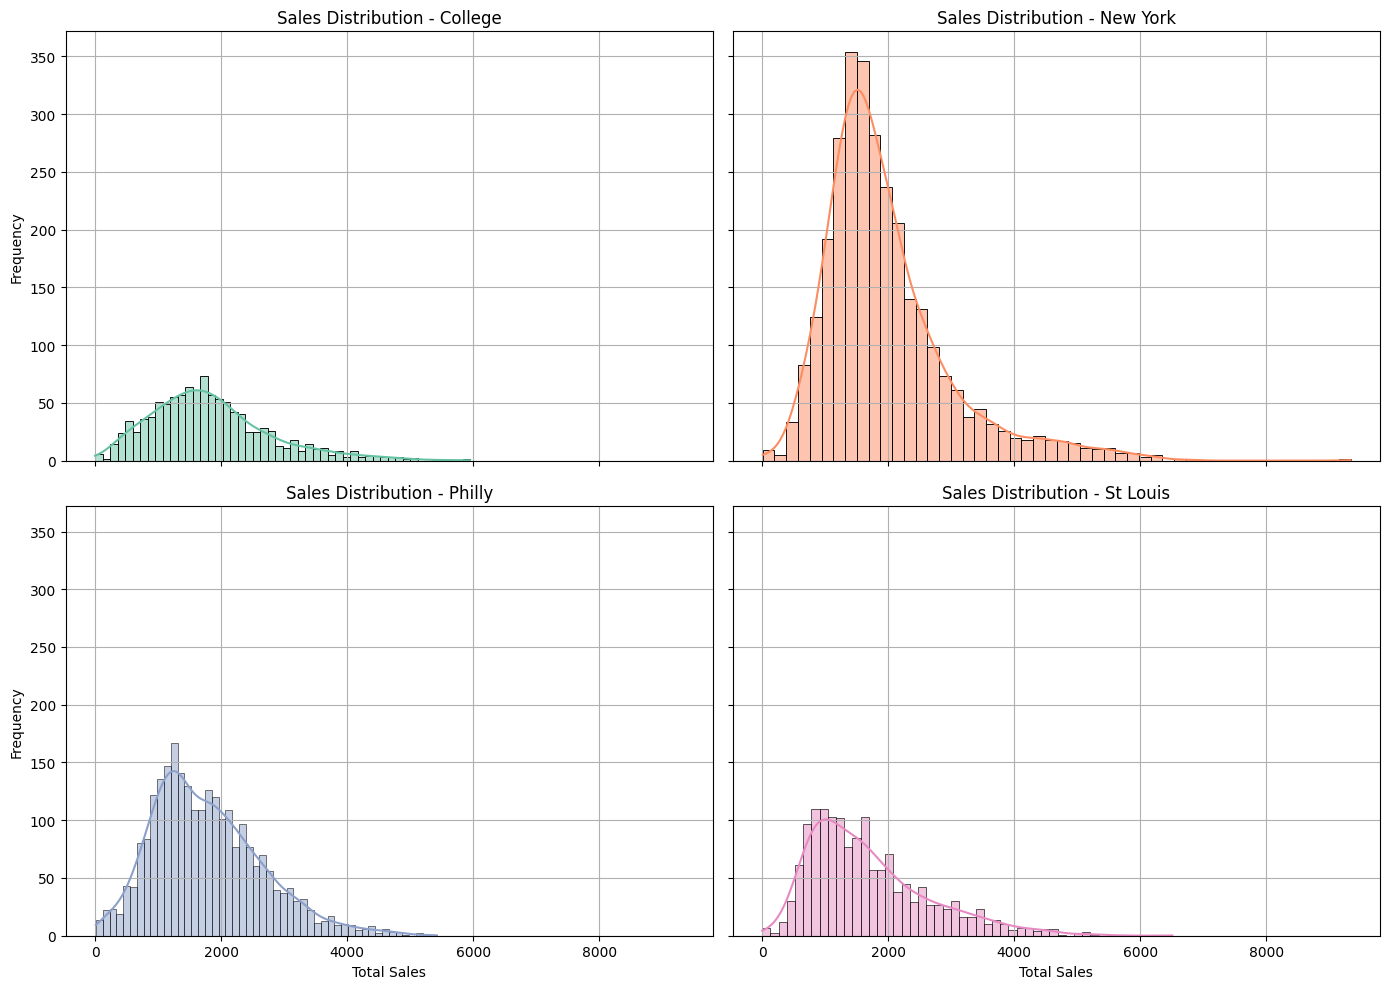

In [16]:
# Get the unique location classes
location_classes = df['location_class'].unique()

# Set up the subplot grid (2x2 if you have 4 classes)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over

# Loop through each location class and plot its histogram
for i, loc_class in enumerate(location_classes):
    ax = axes[i]
    sns.histplot(
        data=df[df['location_class'] == loc_class],
        x='total.sales',
        bins=50,
        kde=True,
        ax=ax,
        color=sns.color_palette("Set2")[i]
    )
    ax.set_title(f"Sales Distribution - {loc_class}")
    ax.set_xlabel("Total Sales")
    ax.set_ylabel("Frequency")
    ax.grid(True)  # Add gridlines

# Remove any unused subplots if less than 4 location classes
for j in range(len(location_classes), 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Sales Histogram by Location Class.png", format="png", dpi=300)
plt.show()

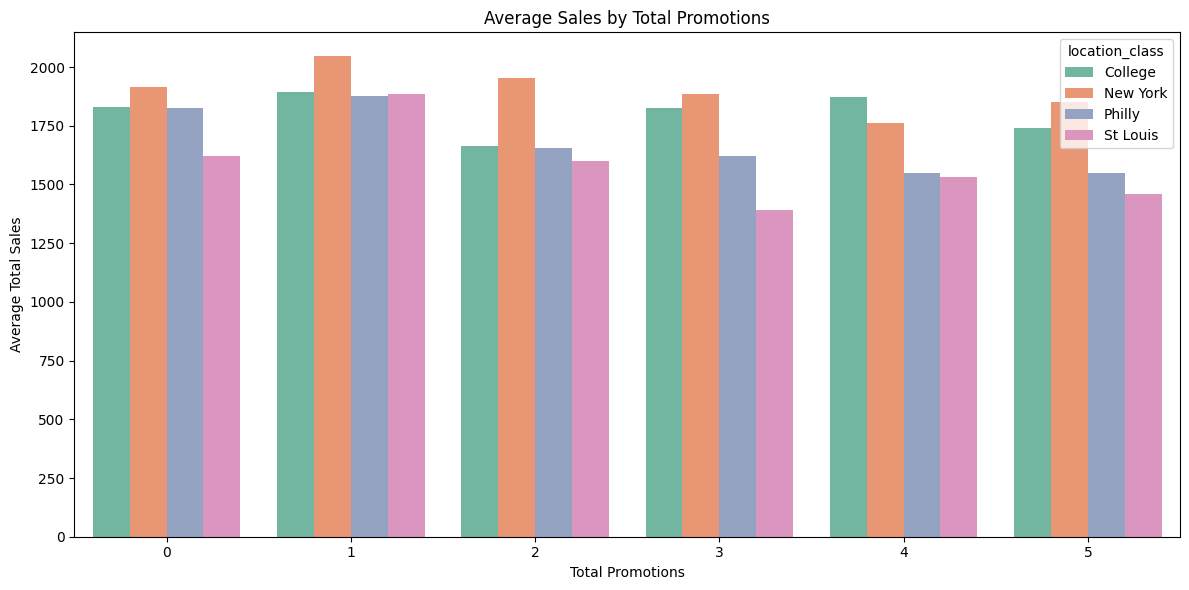

In [13]:
# Group the data by total_promotions and location_class, then compute mean sales
grouped = df.groupby(['total_promotions','location_class'])['total.sales'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x='total_promotions',
    y='total.sales',
    hue='location_class',
    palette='Set2'
)
plt.title("Average Sales by Total Promotions")
plt.xlabel("Total Promotions")
plt.ylabel("Average Total Sales")
#plt.legend(title="Location Class")
plt.tight_layout()
plt.savefig("Average Sales by Total Promotions.png", format="png", dpi=300)
plt.show()

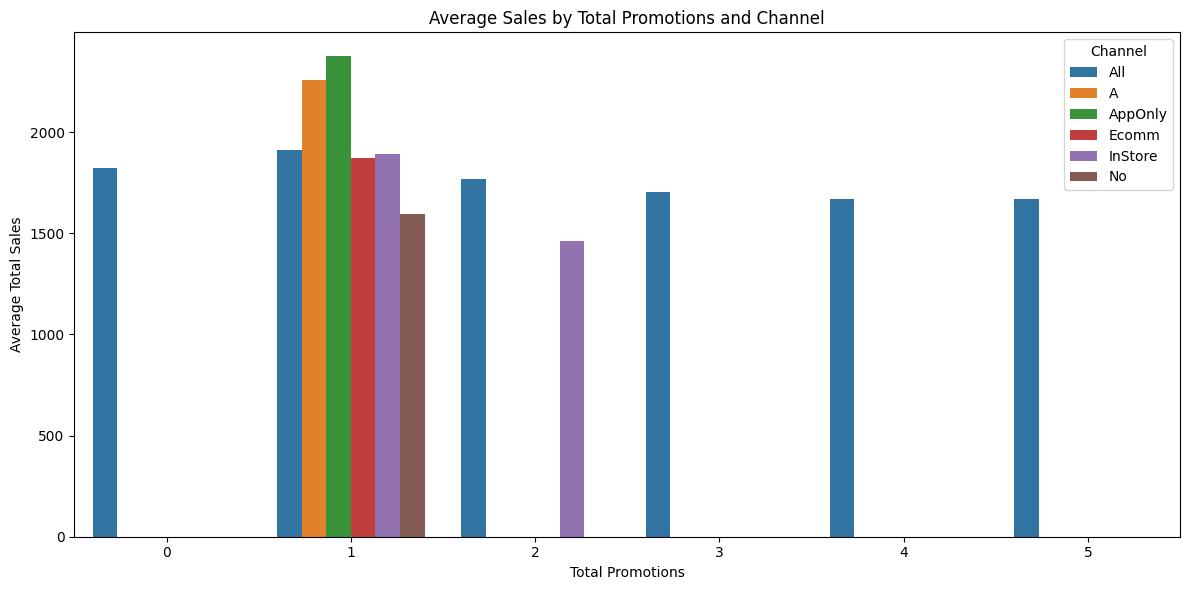

In [19]:
# Step 1: Collapse channel columns into a single column
channel_cols = [
    'channel_All', 'channel_Ecomm', 'channel_InStore',
    'channel_DeliveryOnly', 'channel_No', 'channel_AppOnly', 'channel_A'
]

# Create 'channel' column by finding the channel name where value == 1
df['channel'] = df[channel_cols].idxmax(axis=1).str.replace('channel_', '')

# Step 2: Drop original channel columns
df = df.drop(columns=channel_cols)

# Step 3: Group by total_promotions and channel, then calculate average total.sales
grouped = df.groupby(['total_promotions', 'channel'])['total.sales'].mean().reset_index()

# Step 4: Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x='total_promotions',
    y='total.sales',
    hue='channel',
    palette='tab10'
)
plt.title("Average Sales by Total Promotions and Channel")
plt.xlabel("Total Promotions")
plt.ylabel("Average Total Sales")
plt.legend(title="Channel")
plt.tight_layout()
plt.show()

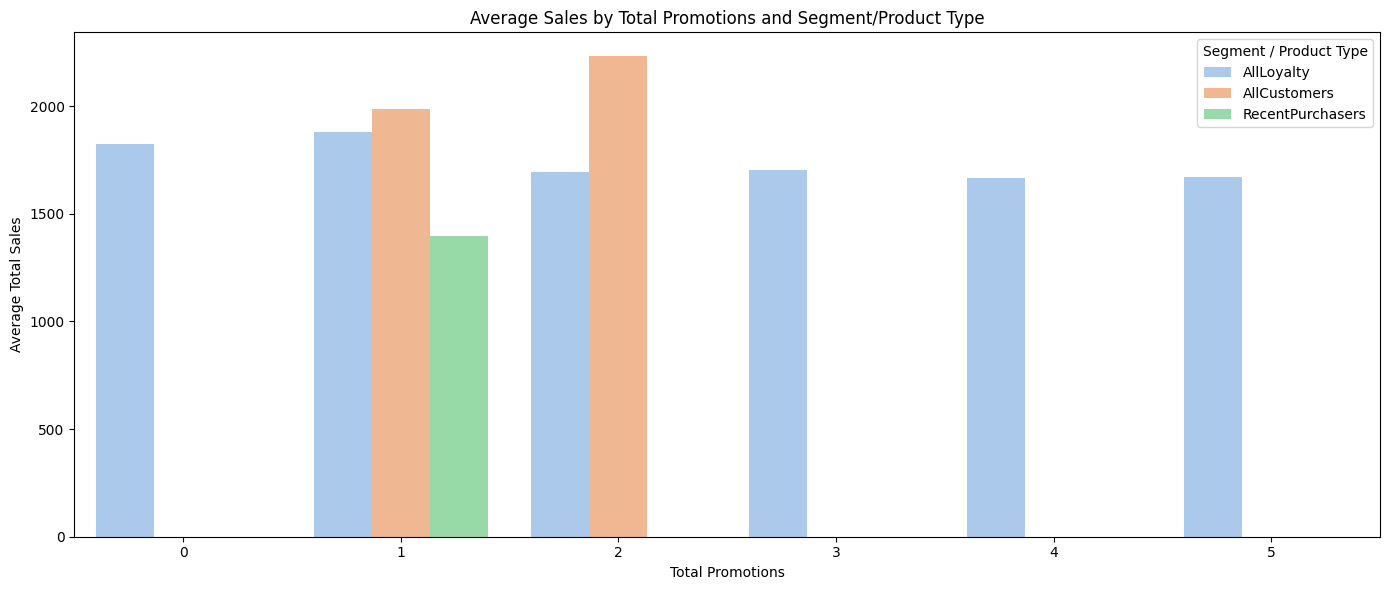

In [20]:
# Step 1: Identify Segment and Product columns
segment_cols = [
    'Segment_AllLoyalty', 'Segment_RecentPurchasers', 'Segment_AllCustomers',
    'Product_Points', 'Product_LTOs', 'Product_FreeDelivery',
    'Product_All', 'Product_Delivery'
]

# Step 2: Create 'segment' column based on which segment/product is marked 1
df['segment'] = df[segment_cols].idxmax(axis=1).str.replace('Segment_', '').str.replace('Product_', '')

# Step 3: Drop original segment/product columns
df = df.drop(columns=segment_cols)

# Step 4: Group by total_promotions and segment, compute avg total.sales
grouped = df.groupby(['total_promotions', 'segment'])['total.sales'].mean().reset_index()

# Step 5: Plot the grouped bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=grouped,
    x='total_promotions',
    y='total.sales',
    hue='segment',
    palette='pastel'
)
plt.title("Average Sales by Total Promotions and Segment/Product Type")
plt.xlabel("Total Promotions")
plt.ylabel("Average Total Sales")
plt.legend(title="Segment / Product Type")
plt.tight_layout()
plt.show()